# The calibration method of $M/PH/N/1 \longrightarrow  \ldots \longrightarrow ./PH/N/1$ queueing model with NS-3 simulation

This experiment consists of a calibration method of queueing model. We consider a tandem model of a wireless network with  𝑀/𝑃𝐻/𝑁/1⟶…⟶./𝑃𝐻/𝑁/1  nodes. The exponential distribution is used to model an arrival distribution. A service time distribution is obtained by PH fitting methods. Approximation of a service time distribution is implemented with Network Simulation 3 NS-3. We researched IEEE 802.11n wireless broadband network.

Queueing model is built with the simulation model of Open Source project in Python `https://github.com/ipu69/pyqumo`.

In [1]:
import json
from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tabulate import tabulate

from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.fitting.acph2 import fit_acph2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang, Exponential
from pyqumo.cqumo.sim import simulate_tandem

## Loading of datasets from NS-3 model.

In our study, we consider a wireless broadband network with 3 base stations and a gateway. All packets are forwarded from the first station through the station system $S_1 \rightarrow S_2 \rightarrow S_3$ to the gateway $S_g$. 

The base station has the following technical parameters:
* protocol 802.11n;
* MAC layer's buffer size is equal to 500 (default value).
* (and also some characteristics).

NS-3 generated 1 000 000 packets. We collected three data samples. They are response times between sta $S_1$ and sta $S_2$, response times between sta $S_2$ and sta $S_3$, and response times between sta $S_4$ and gateway $S_g$. Also, we piled up a network end-to-delay that is equal to an average time spent by packets on the network.

`JSON-files` include response times between stations in a wireless network. 

The sample size is equal to the count of generated packets. In our case, there are 1 000 000 samples in each case.

In [2]:
''' LOADING NS-3 DATA ''' 
interval_1 = pd.read_json(r'data/ns3_dataset/intervals_1.json')
interval_2 = pd.read_json(r'data/ns3_dataset/intervals_2.json')
interval_3 = pd.read_json(r'data/ns3_dataset/intervals_3.json')
# interval_1 = pd.read_json(r'data/ns3_dataset/intervals_g_1.json')
# interval_2 = pd.read_json(r'data/ns3_dataset/intervals_g_2.json')
# interval_3 = pd.read_json(r'data/ns3_dataset/intervals_g_3.json')

So, we have response time data sets. We need to fit a service time distribution. First of all, it is necessary to get the first three noncentral moments.

**So, k-th non central moment is calculated as**

\begin{equation}
\mu^{\left( k\right) }\equiv\mathbb{E}\{X^{k}\},\quad k=1,2,\ldots \,\text{,}
\end{equation}

In [3]:
def get_non_central_moment(sample: pd.DataFrame, k:int=1) -> np.float64:
    "Calculating of k-th non central moment"
    return np.mean(sample[0] ** k)

In [4]:
''' 
Dataclass of commincation link. 
It is consists NS-3 data and 1st, 2nd, and 3rd moments
'''
@dataclass
class S2SLink:
    dataset: pd.DataFrame
    m1: float
    m2: float
    m3: float

We need to prepare service time distribution. It can be solve with PH fitting methods. In our exploration we used fitting algorithms designed by Johnson and `Mary A. Johnson & Michael R. Taaffe (1989) Matching moments to phase distributions: Mixtures of erlang distributions of common order, Communications in Statistics. Stochastic Models, 5:4, 711-743, DOI: 10.1080/15326348908807131`

In [5]:
def get_service_dist(e2e_link: dataclass) -> list:
    srv_dist = [None]*len(e2e_link)
    for i in range(len(e2e_link)):
        srv, _ = fit_mern2(moments=[e2e_link[i].m1, 
                                  e2e_link[i].m2, 
                                  e2e_link[i].m3])
#         srv, _ = fit_acph2(moments=[e2e_link[i].m1, 
#                                     e2e_link[i].m2, 
#                                     e2e_link[i].m3], strict=False)
        srv_dist[i] = srv
    
    return srv_dist

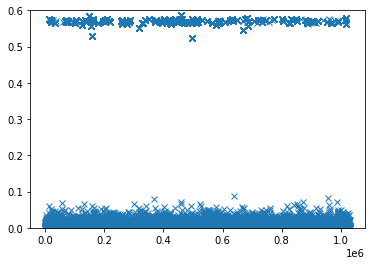

In [6]:
# plt.hist(interval_1, density=True, bins=20)
plt.ylim([0, .6]);
plt.plot(interval_1, 'x')

Let each link will be approximated especial **Phase Type distribution**:

In [7]:
s12_link = S2SLink(dataset=interval_1, 
                   m1=get_non_central_moment(interval_1, k=1),
                   m2=get_non_central_moment(interval_1, k=2),
                   m3=get_non_central_moment(interval_1, k=3))

s23_link = S2SLink(dataset=interval_1, 
                   m1=get_non_central_moment(interval_2, k=1),
                   m2=get_non_central_moment(interval_2, k=2),
                   m3=get_non_central_moment(interval_2, k=3))

s34_link = S2SLink(dataset=interval_1, 
                   m1=get_non_central_moment(interval_3, k=1),
                   m2=get_non_central_moment(interval_3, k=2),
                   m3=get_non_central_moment(interval_3, k=3))
e2e_link = [s12_link, s23_link, s34_link]

service_dist = get_service_dist(e2e_link) 

In [8]:
first_moments = [s12_link.m1,
                 s23_link.m1,
                 s34_link.m1]
first_moments

[0.002964871946332217, 0.000495260959584664, 0.0007198431195809771]

In [9]:
arr = Exponential(100)
ret = simulate_tandem(arr, service_dist, 500, 1_000_000)
ret.delivery_delays

[Statistics(avg=0.5746429016930852, var=0.5016479190542622, std=0.7082710773808727, count=99999),
 Statistics(avg=0.0, var=0.0, std=0.0, count=0),
 Statistics(avg=0.0, var=0.0, std=0.0, count=0)]

In [10]:
samples = 100
e2et = np.zeros(samples)

for i in range(samples):
    ret = simulate_tandem(arr, service_dist, 500, 1_000_000)
    e2et[i] = ret.delivery_delays[0].avg

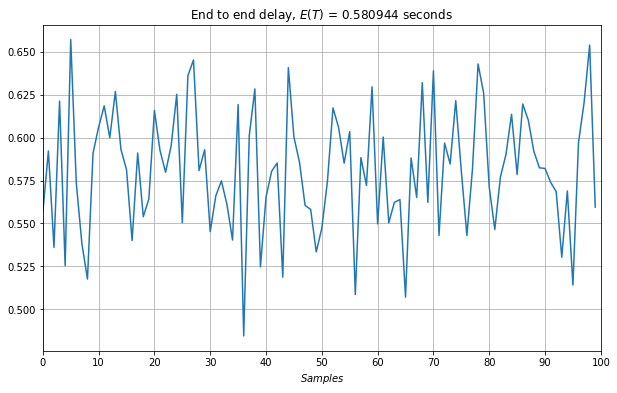

In [11]:
plt.figure(figsize=(10,6))
plt.title(f'End to end delay, $E(T)$ = {e2et.mean():.6f} seconds');
plt.plot(e2et, '-');
plt.grid();
plt.xlabel(r'$Samples$');
plt.xlim([0, samples]);
plt.xticks(np.arange(0, 110, 10));

## Detection and excluding outliers in data sets of responce time

In [12]:
interval_1_filter = interval_1[interval_1[0] <.5]
interval_2_filter = interval_2[interval_2[0] <.5]
interval_3_filter = interval_3[interval_3[0] <.5]

s12_link_filter = S2SLink(dataset=interval_1, 
                          m1=get_non_central_moment(interval_1_filter, k=1),
                          m2=get_non_central_moment(interval_1_filter, k=2),
                          m3=get_non_central_moment(interval_1_filter, k=3))

s23_link_filter = S2SLink(dataset=interval_1, 
                          m1=get_non_central_moment(interval_2_filter, k=1),
                          m2=get_non_central_moment(interval_2_filter, k=2),
                          m3=get_non_central_moment(interval_2_filter, k=3))

s34_link_filter = S2SLink(dataset=interval_1, 
                          m1=get_non_central_moment(interval_3_filter, k=1),
                          m2=get_non_central_moment(interval_3_filter, k=2),
                          m3=get_non_central_moment(interval_3_filter, k=3))
e2e_link_filter = [s12_link_filter, s23_link_filter, s34_link_filter]

service_dist_filter = get_service_dist(e2e_link_filter)

samples = 100
e2et_filter = np.zeros(samples)

for i in range(samples):
    ret_filter = simulate_tandem(arr, service_dist_filter, 500, 1_000_000)
    e2et_filter[i] = ret_filter.delivery_delays[0].avg

In [35]:
s23_link_filter.m1

0.0004914046255357437

In [13]:
delay_sim = [0.00387008,
             0.00364331,
             0.00354825,
             0.00454046,
             0.00364631,
             0.0038975,
             0.00374635,
             0.00361165,
             0.00406019,
             0.00375125]

delay100k = [0.00251827,
             0.00488137,
             0.00430713,
             0.00422884,
             0.00361939,
             0.00324406,
             0.00397321,
             0.00302057,
             0.00210678,
             0.00274328,
             0.00304363,
             0.00354029,
             0.00432225,
             0.00297623]

delay500k = [0.0035397,
             0.0039882,
             0.00394872,
             0.0044488,
             0.00448644,
             0.00392004,
             0.00336415,
             0.00371099,
             0.00313266,
             0.0041309,
             0.00460812,
             0.00439093]

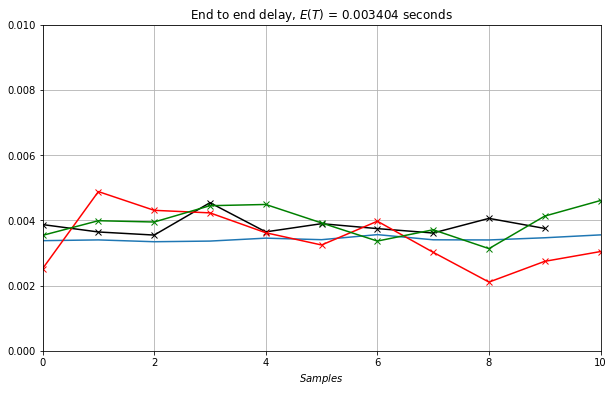

In [14]:
plt.figure(figsize=(10,6))
plt.title(f'End to end delay, $E(T)$ = {e2et_filter.mean():.6f} seconds');
plt.plot(e2et_filter, '-');
plt.plot(delay_sim, '-kx')
plt.plot(delay100k, '-rx')
plt.plot(delay500k, '-gx')
plt.grid();
plt.xlabel(r'$Samples$');
plt.ylim([0, .01]);
plt.xlim([0, 10]);
# plt.xticks(np.arange(0, 110, 10));



## &#11015;  DRAW &#11015;

In [15]:
tandem5_interval_0 = pd.read_json(r'data/ns3_dataset/802_11_N_result_0.json')
tandem5_interval_1 = pd.read_json(r'data/ns3_dataset/802_11_N_result_1.json')
tandem5_interval_2 = pd.read_json(r'data/ns3_dataset/802_11_N_result_2.json')
tandem5_interval_3 = pd.read_json(r'data/ns3_dataset/802_11_N_result_3.json')

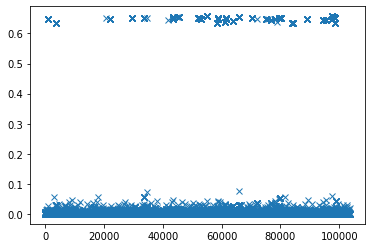

In [16]:
# plt.ylim([0, .6]);
plt.plot(tandem5_interval_0, 'x')

In [17]:
s12_link = S2SLink(dataset=interval_1, 
                   m1=get_non_central_moment(tandem5_interval_0, k=1),
                   m2=get_non_central_moment(tandem5_interval_0, k=2),
                   m3=get_non_central_moment(tandem5_interval_0, k=3))

s23_link = S2SLink(dataset=interval_1, 
                   m1=get_non_central_moment(tandem5_interval_1, k=1),
                   m2=get_non_central_moment(tandem5_interval_1, k=2),
                   m3=get_non_central_moment(tandem5_interval_1, k=3))

s34_link = S2SLink(dataset=interval_1, 
                   m1=get_non_central_moment(tandem5_interval_2, k=1),
                   m2=get_non_central_moment(tandem5_interval_2, k=2),
                   m3=get_non_central_moment(tandem5_interval_2, k=3))

s45_link = S2SLink(dataset=interval_1, 
                   m1=get_non_central_moment(tandem5_interval_3, k=1),
                   m2=get_non_central_moment(tandem5_interval_3, k=2),
                   m3=get_non_central_moment(tandem5_interval_3, k=3))

e2e_link = [s12_link, s23_link, s34_link, s45_link]

service_dist = get_service_dist(e2e_link) 

In [18]:
first_moments = [s12_link.m1,
                 s23_link.m1,
                 s34_link.m1,
                 s45_link.m1]
first_moments

[0.00745780347343821,
 0.0007589720847351541,
 0.0010998633855556958,
 0.001271105721515451]

In [19]:
service_dist

[(HyperErlang: probs=[0.985, 0.0154], shapes=[6, 6], params=[1.02e+06, 12.4]),
 (HyperErlang: probs=[0.999, 0.000522], shapes=[1, 1], params=[1.47e+03, 6.43]),
 (HyperErlang: probs=[0.997, 0.0032], shapes=[1, 1], params=[1.96e+03, 5.42]),
 (HyperErlang: probs=[0.996, 0.00414], shapes=[1, 1], params=[2.03e+03, 5.31])]

In [20]:
len(tandem5_interval_2)

205742

In [21]:
service_dist[0].cv

8.650678917881338

In [22]:
fit_acph2(moments=[s12_link.m1, s12_link.m2, s12_link.m3], strict=False)

((PH: s=[[-3.18, 3.18], [0, -1.31e+03]], p=[0.0213, 0.979]),
 array([4.18689265e-15, 9.25391557e-15, 4.57196832e-01]))

In [23]:
from scipy.stats import moment
moment(interval_1[0], moment=1)

0.0

In [24]:
moment(interval_1[0], moment=2)

0.0012717474920610615

In [25]:
moment(interval_1[0], moment=3)

0.0007160885763909009

In [26]:
s12_link.m1

0.00745780347343821

In [27]:
s12_link.m2

0.004217812222848122

In [28]:
s12_link.m3

0.002728312285347806

In [29]:
get_skewness(s12_link.m1, s12_link.m2, s12_link.m3)

9.812059117316883

(array([1.70047297e+01, 3.47932010e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.97045729e-04, 6.68195142e-02]),
 array([1.56072000e-04, 5.87301648e-02, 1.17304258e-01, 1.75878350e-01,
        2.34452443e-01, 2.93026536e-01, 3.51600629e-01, 4.10174722e-01,
        4.68748814e-01, 5.27322907e-01, 5.85897000e-01]),
 <BarContainer object of 10 artists>)

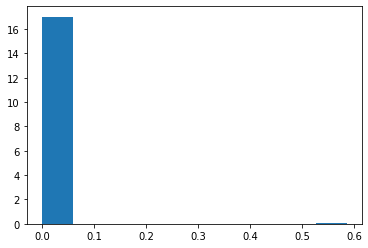

In [19]:
plt.hist(interval_1, density=True)

(array([1.74371717e+01, 3.29505229e-04, 1.18283928e-04, 9.29373724e-05,
        3.37954081e-05, 5.06931122e-05, 1.26732781e-04, 6.75908163e-05,
        1.01386224e-04, 7.60396683e-05]),
 array([9.82880000e-05, 5.74437592e-02, 1.14789230e-01, 1.72134702e-01,
        2.29480173e-01, 2.86825644e-01, 3.44171115e-01, 4.01516586e-01,
        4.58862058e-01, 5.16207529e-01, 5.73553000e-01]),
 <BarContainer object of 10 artists>)

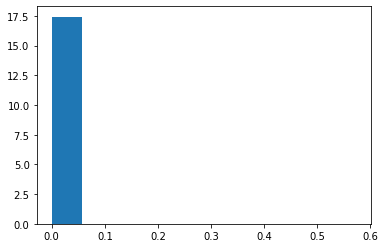

In [20]:
plt.hist(interval_2, density=True)

(array([1.52761567e+01, 1.66445616e-03, 2.01954014e-03, 7.10167961e-04,
        6.95372795e-04, 1.58308275e-03, 1.35375768e-03, 7.24963127e-04,
        9.46890614e-04, 7.39758292e-06]),
 array([9.87280000e-05, 6.55186552e-02, 1.30938582e-01, 1.96358510e-01,
        2.61778437e-01, 3.27198364e-01, 3.92618291e-01, 4.58038218e-01,
        5.23458146e-01, 5.88878073e-01, 6.54298000e-01]),
 <BarContainer object of 10 artists>)

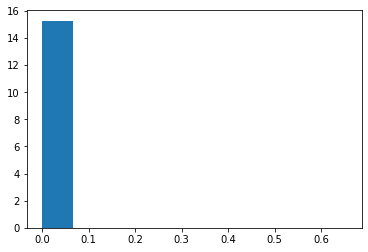

In [21]:
plt.hist(interval_3, density=True)

In [29]:
service_dist[2].cv

0.6628420361390814

In [32]:
interval_1.quantile(q=0.95, axis=0)


0    0.002583
Name: 0.95, dtype: float64

In [33]:
df = pd.DataFrame(np.array([[1, 1], [2, 10], [3, 100], [4, 100]]),
                  columns=['a', 'b'])
df

,a,b
0,1,1
1,2,10
2,3,100
3,4,100


In [39]:
interval_1[interval_1[0] >.1]

,0
11209,0.574999
11210,0.574999
11211,0.574999
11212,0.574999
11213,0.574999
...,...
1017582,0.562499
1017583,0.562499
1017584,0.562499
1017585,0.562499


In [40]:
interval_2[interval_2[0] >.1]

,0
22490,0.251458
39390,0.437954
71580,0.378841
120107,0.148333
132031,0.126102
...,...
1920992,0.423508
1966347,0.412127
1984603,0.372251
1985564,0.459197


In [41]:
interval_3[interval_3[0] >.1]

,0
22494,0.199946
39301,0.569384
39302,0.569384
39303,0.569384
39304,0.569384
...,...
1987863,0.485857
1987864,0.485857
1987865,0.485857
1987866,0.485857
